![UBA](assets/UBA_header_black.png)

In [1]:
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FixedLocator
import folium

In [2]:
USUARIOS_CSV = pathlib.Path("./datasets/badata_ecobici_usuarios_2024.csv")
RECORRIDOS_CSV = pathlib.Path("./datasets/badata_ecobici_recorridos_realizados_2024.csv")

# Ingesta de los datos

In [3]:
users_df = pd.read_csv(USUARIOS_CSV)
rides_df = pd.read_csv(RECORRIDOS_CSV)

# Características generales del dataset seleccionado
Contiene información sobre los viajes realizados a través del servicio público de bicicletas BA Ecobici, que opera en la Ciudad Autónoma de Buenos Aires.

### Usuarios
Contiene el listado de usuarios del servicio.

In [4]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197079 entries, 0 to 197078
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id_usuario      197079 non-null  int64 
 1   genero_usuario  197079 non-null  object
 2   edad_usuario    197079 non-null  int64 
 3   fecha_alta      197079 non-null  object
 4   hora_alta       197079 non-null  object
dtypes: int64(2), object(3)
memory usage: 7.5+ MB


In [5]:
users_df.head()

,id_usuario,genero_usuario,edad_usuario,fecha_alta,hora_alta
0,1083579,OTHER,23,2024-01-01,01:59:02
1,1083608,OTHER,36,2024-01-01,02:55:46
2,1083612,OTHER,38,2024-01-01,03:13:15
3,1083616,FEMALE,21,2024-01-01,03:40:54
4,1083631,MALE,36,2024-01-01,05:02:35


In [6]:
users_df.describe()

,id_usuario,edad_usuario
count,1.970790e+05,197079.000000
mean,1.182078e+06,30.764521
std,5.689283e+04,18.896208
min,1.083538e+06,4.000000
25%,1.132808e+06,21.000000
50%,1.182078e+06,27.000000
75%,1.231348e+06,37.000000
max,1.280619e+06,2021.000000


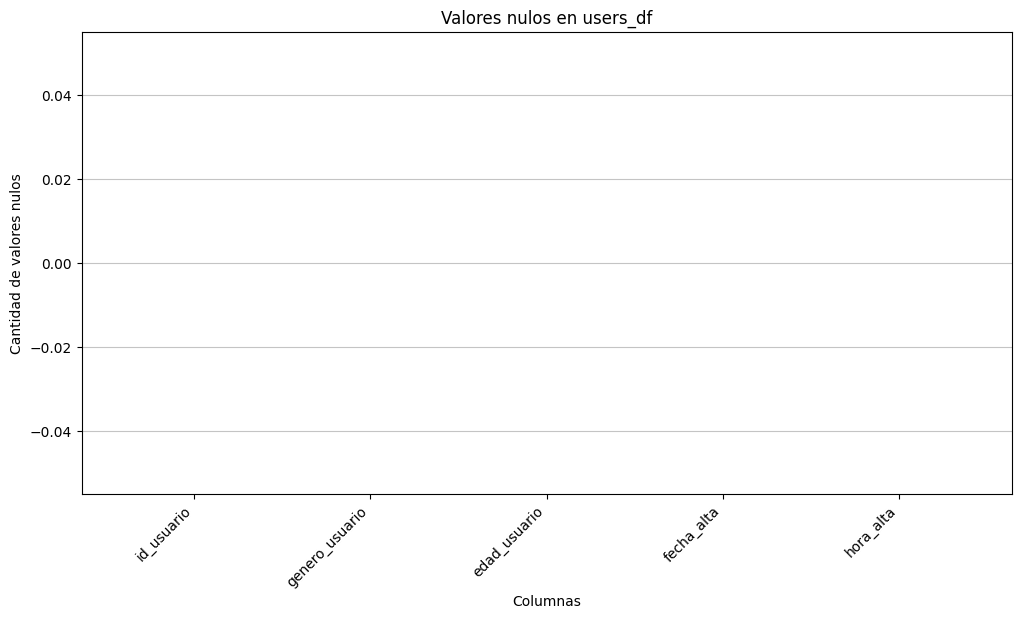

In [7]:
# Exploración de valores nulos
plt.figure(figsize=(12, 6))
plt.grid(axis='y', alpha=0.75)
plt.bar(users_df.columns, users_df.isnull().sum(), align='center', zorder=2)
plt.xticks(rotation=45, ha='right')
plt.title('Valores nulos en users_df')
plt.xlabel('Columnas')
plt.ylabel('Cantidad de valores nulos')
plt.show()

<Axes: xlabel='edad_usuario'>

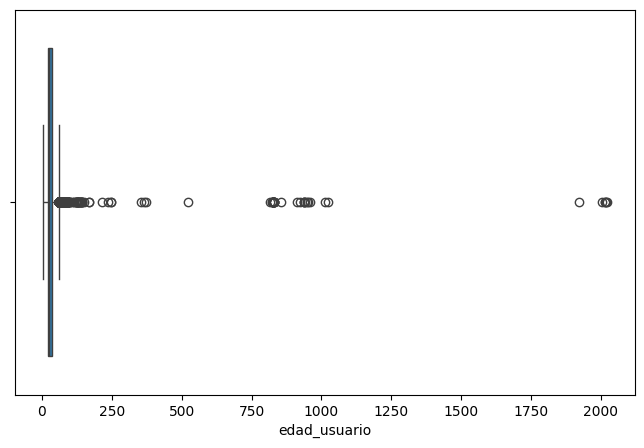

In [8]:
# boxplot de edades
plt.figure(figsize=(8, 5))
sns.boxplot(x=users_df['edad_usuario'])

In [32]:
# Media moda mediana de edades
mean = users_df['edad_usuario'].mean().round(2)
median = users_df['edad_usuario'].median().round(2)
mode = users_df['edad_usuario'].mode()[0].round(2)

print("Media:", mean)
print("Mediana:", median)
print("Moda:", mode)

Media: 30.76
Mediana: 27.0
Moda: 18


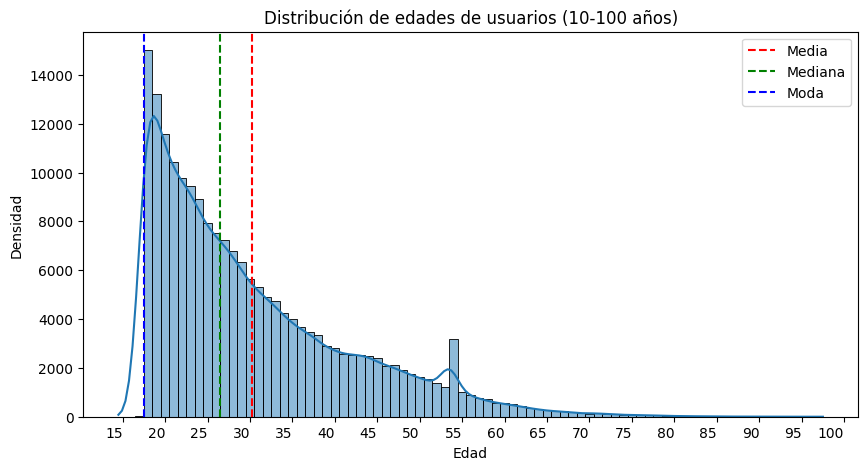

In [ ]:
# Histograma de edades
mask_edad = (users_df['edad_usuario'] >= 10) & (users_df['edad_usuario'] <= 100)
plt.figure(figsize=(10, 5))
ax = sns.histplot(users_df[mask_edad]['edad_usuario'], kde=True, binwidth=1)
ticks = [t + 0.5 for t in range(10, 101, 5)]  # Esto es para centrar los bines en los ticks
ax.xaxis.set_major_locator(FixedLocator(ticks))
ax.set_xticklabels([str(int(tick)) for tick in ticks], ha='right')
plt.title('Distribución de edades de usuarios (10-100 años)')
plt.xlabel('Edad')
plt.ylabel('Densidad')

# Media, moda y mediana
ax.axvline(mean, color='r', linestyle='--', label='Media')
ax.axvline(median, color='g', linestyle='--', label='Mediana')
ax.axvline(mode, color='b', linestyle='--', label='Moda')
ax.legend()

plt.show()


Text(0, 0.5, 'Densidad')

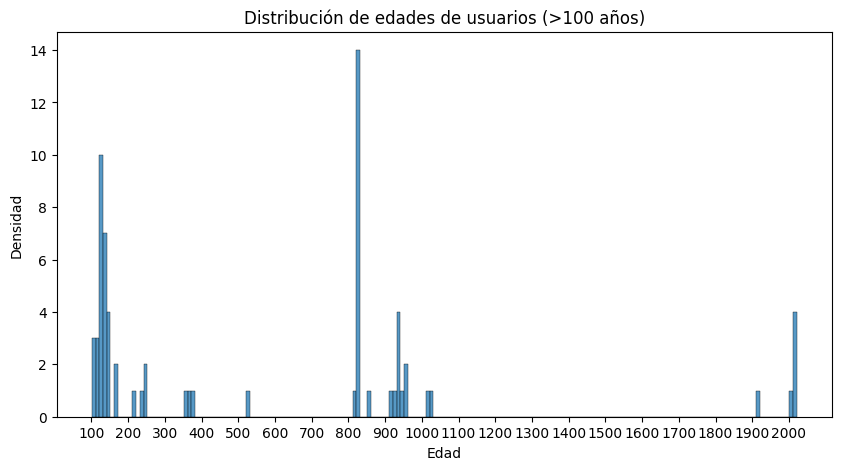

In [10]:
# Histograma de edades de mas de 100 años
mask_edad = users_df["edad_usuario"] > 100
plt.figure(figsize=(10, 5))
sns.histplot(users_df[mask_edad]['edad_usuario'], binwidth=10)
plt.title('Distribución de edades de usuarios (>100 años)')
plt.xticks(range(100, users_df['edad_usuario'].max() + 1, 100))
plt.xlabel('Edad')
plt.ylabel('Densidad')

In [11]:
# 10 usuarios mas 'viejos'
users_df.sort_values(by='edad_usuario', ascending=False).head(10)

,id_usuario,genero_usuario,edad_usuario,fecha_alta,hora_alta
56690,1109473,MALE,2021,2024-02-11,20:24:45
104417,1238144,MALE,2019,2024-10-27,20:08:47
124365,1130915,FEMALE,2016,2024-03-21,21:19:50
184254,1202670,MALE,2016,2024-09-07,18:39:34
66885,1189702,FEMALE,2004,2024-08-09,22:34:35
10936,1150325,FEMALE,1921,2024-04-29,13:33:57
137312,1277262,OTHER,1022,2024-12-27,13:11:42
62421,1167228,MALE,1012,2024-06-16,15:20:11
18616,1199423,OTHER,960,2024-09-02,17:37:56
92904,1279416,OTHER,952,2024-12-30,09:20:27


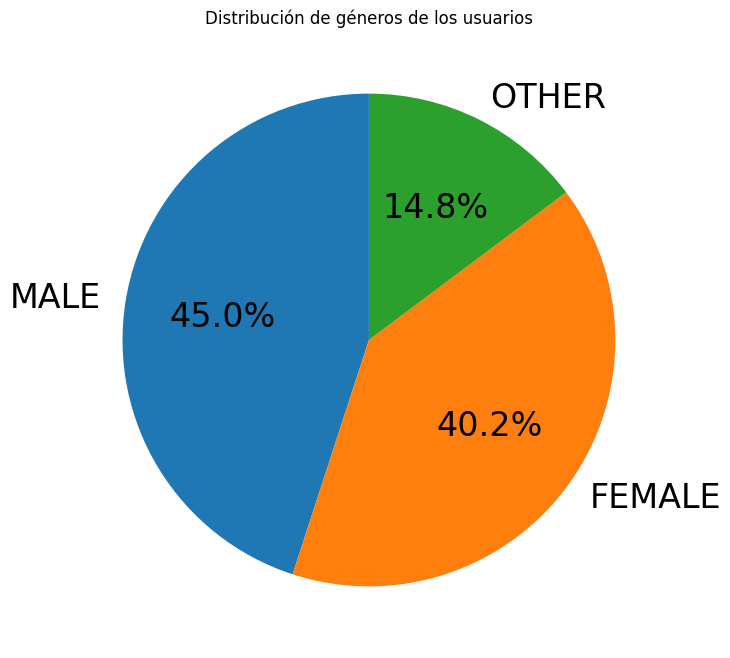

In [12]:
# Pie chart de los géneros de usuarios
plt.figure(figsize=(8, 8))
users_df['genero_usuario'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, fontsize=24)
plt.title('Distribución de géneros de los usuarios')
plt.ylabel('')
plt.show()

### Recorridos
Contiene información de los viajes realizados.plt.bar(range(len(users_df.columns)), users_df.isnull().sum())plt.xticks(range(len(users_df.columns)), users_df.columns, rotation=45)plt.tight_layout()
plt.show()

In [13]:
rides_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3560404 entries, 0 to 3560403
Data columns (total 17 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   id_recorrido                int64  
 1   duracion_recorrido          int64  
 2   fecha_origen_recorrido      object 
 3   id_estacion_origen          int64  
 4   nombre_estacion_origen      object 
 5   direccion_estacion_origen   object 
 6   long_estacion_origen        float64
 7   lat_estacion_origen         float64
 8   fecha_destino_recorrido     object 
 9   id_estacion_destino         int64  
 10  nombre_estacion_destino     object 
 11  direccion_estacion_destino  object 
 12  long_estacion_destino       float64
 13  lat_estacion_destino        float64
 14  id_usuario                  float64
 15  modelo_bicicleta            object 
 16  genero                      object 
dtypes: float64(5), int64(4), object(8)
memory usage: 461.8+ MB


In [14]:
rides_df.head()

,id_recorrido,duracion_recorrido,fecha_origen_recorrido,id_estacion_origen,nombre_estacion_origen,direccion_estacion_origen,long_estacion_origen,lat_estacion_origen,fecha_destino_recorrido,id_estacion_destino,nombre_estacion_destino,direccion_estacion_destino,long_estacion_destino,lat_estacion_destino,id_usuario,modelo_bicicleta,genero
0,24496816,17,2024-12-31 08:18:58,202,001 - FACULTAD DE DERECHO,Av. Pres. Figueroa Alcorta 2120,-58.390602,-34.583749,2024-12-31 08:19:15,202,001 - FACULTAD DE DERECHO,Av. Pres. Figueroa Alcorta 2120,-58.390602,-34.583749,1166678.0,FIT,FEMALE
1,24492524,2,2024-12-30 19:21:45,251,388 - Plaza Jose C Paz,Dr. Prof. Pedro Chutro 2881,-58.402483,-34.641728,2024-12-30 19:21:47,41,041 - PARQUE PATRICIOS II,Av Caseros 3015,-58.405888,-34.637123,1133415.0,FIT,FEMALE
2,24493951,0,2024-12-30 21:08:03,418,345 - Plaza Mafalda,Conde & Concepción Arenal,-58.444580,-34.580938,NaN,418,345 - Plaza Mafalda,Conde & Concepción Arenal,-58.444580,-34.580938,1158360.0,ICONIC,FEMALE
3,24494848,6575,2024-12-30 23:22:17,177,177 -PLANETARIO,Av. Belisario Roldán y Av. Sarmiento,-58.411598,-34.571079,2024-12-31 01:11:52,336,207 - PLAZA ARENALES,Nueva York 3949,-58.511146,-34.599731,1224331.0,FIT,FEMALE
4,24495039,3162,2024-12-30 23:52:00,359,250 - Fleni,2292 Montañeses,-58.450479,-34.555602,2024-12-31 00:44:42,85,085 - AGUERO,"Aguero & Mansilla, Lucio Norberto, General",-58.409178,-34.594806,1280053.0,ICONIC,FEMALE


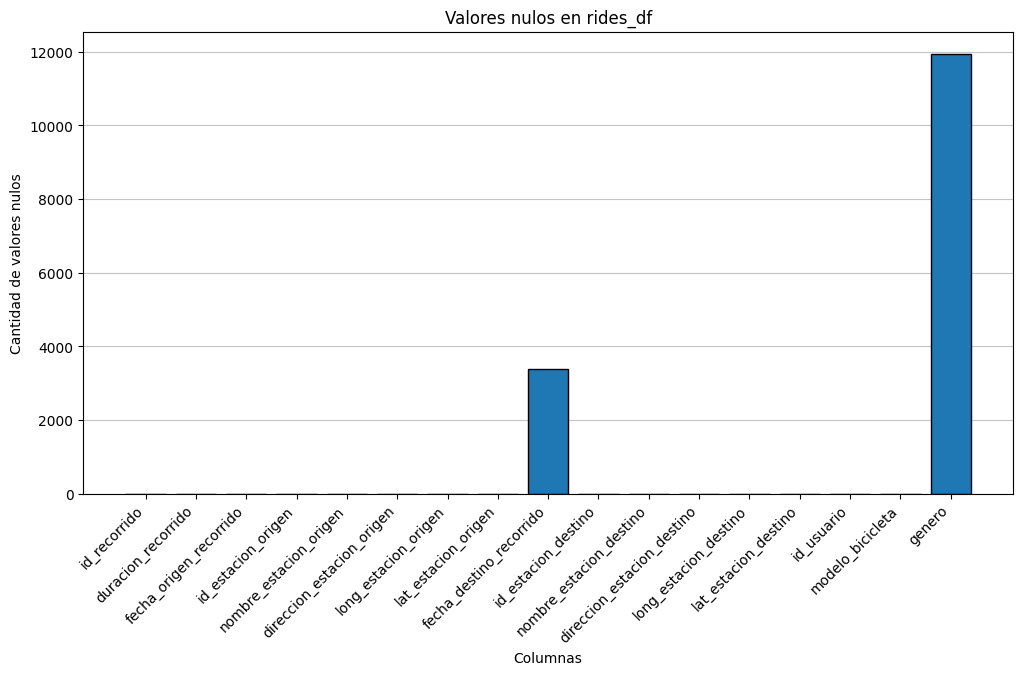

In [15]:
# Exploración de valores nulos
plt.figure(figsize=(12, 6))
plt.grid(axis='y', alpha=0.75)
plt.bar(rides_df.columns, rides_df.isnull().sum(), align='center', zorder=2, edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.title('Valores nulos en rides_df')
plt.xlabel('Columnas')
plt.ylabel('Cantidad de valores nulos')
plt.show()

In [16]:
# Recorrido mas largo en días
rides_df["duracion_recorrido"].max()/3600/24

np.float64(29.758854166666666)

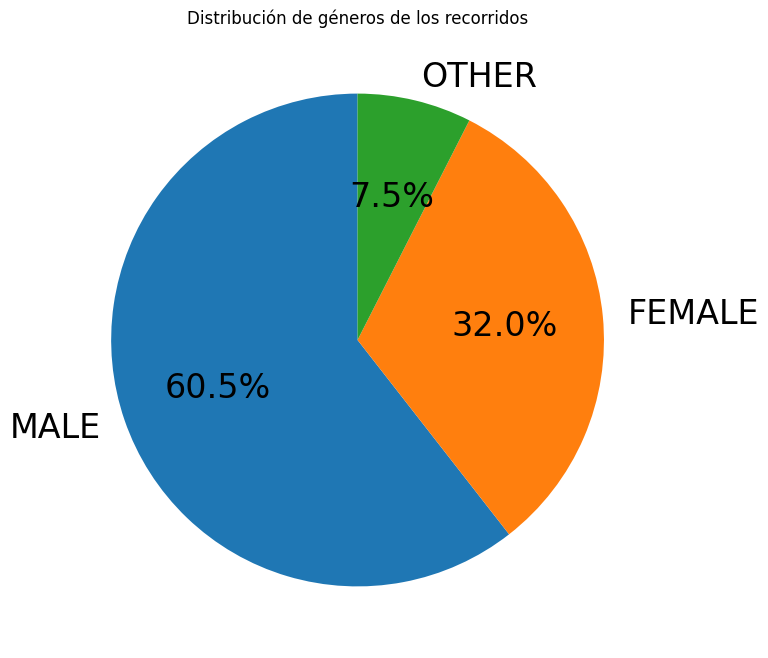

In [17]:
# Pie chart de generos de los recorridos
plt.figure(figsize=(8, 8))
rides_df['genero'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, fontsize=24)
plt.title('Distribución de géneros de los recorridos')
plt.ylabel('')
plt.show()

In [18]:
# Estaciones más usadas para iniciar recorridos
origin_top_stations = rides_df['nombre_estacion_origen'].value_counts().sort_values(ascending=False).head(5)
print(origin_top_stations)

nombre_estacion_origen
147 - Constitución           38284
014 - Pacifico               37594
368 - PLAZA DE LA SHOÁ       37201
005 - Plaza Italia           34547
001 - FACULTAD DE DERECHO    30955
Name: count, dtype: int64


In [19]:
# Estaciones más usadas para terminar recorridos
destination_top_stations = rides_df['nombre_estacion_destino'].value_counts().sort_values(ascending=False).head(5)
print(destination_top_stations)

nombre_estacion_destino
147 - Constitución           38363
368 - PLAZA DE LA SHOÁ       37425
014 - Pacifico               37278
005 - Plaza Italia           34607
001 - FACULTAD DE DERECHO    30897
Name: count, dtype: int64


In [20]:
# Mapa
caba_coords = [-34.6037, -58.3816]
m = folium.Map(location=caba_coords, zoom_start=13, tiles='OpenStreetMap')

# Origenes
cols_ori = ['nombre_estacion_origen', 'lat_estacion_origen', 'long_estacion_origen']
coords = (rides_df[rides_df['nombre_estacion_origen'].isin(origin_top_stations.index)]
          [cols_ori].dropna().drop_duplicates('nombre_estacion_origen'))

for _, r in coords.iterrows():
    nombre, lat, lon = r['nombre_estacion_origen'], float(r['lat_estacion_origen']), float(r['long_estacion_origen'])
    
    folium.Marker([lat, lon], popup=nombre, tooltip=nombre,
                  icon=folium.Icon(color='green', icon='play', prefix='fa')).add_to(m)
    
    folium.Marker([lat, lon],
        icon=folium.DivIcon(
            html=f'<div style="transform:translate(12px,-18px);'
             'background:#fff;border:1px solid rgba(0,0,0,.2);border-radius:4px;'
             'padding:2px 6px;font-size:12px;font-weight:700;color:#000;'
             'display:inline-block;max-width:180px;white-space:nowrap;'
             'overflow:hidden;text-overflow:ellipsis;pointer-events:none;">'
             f'{nombre}</div>'
        )
    ).add_to(m)

m.save('mapa_caba_top_estaciones_orig.html')

In [21]:
# Mapa
caba_coords = [-34.6037, -58.3816]
m = folium.Map(location=caba_coords, zoom_start=13, tiles='OpenStreetMap')

# Destinos
cols_dest = ['nombre_estacion_destino', 'lat_estacion_destino', 'long_estacion_destino']
coords_dest = (rides_df[rides_df['nombre_estacion_destino'].isin(destination_top_stations.index)]
               [cols_dest].dropna().drop_duplicates('nombre_estacion_destino'))

for _, r in coords_dest.iterrows():
    nombre, lat, lon = r['nombre_estacion_destino'], float(r['lat_estacion_destino']), float(r['long_estacion_destino'])
    folium.Marker([lat, lon], popup=nombre, tooltip=nombre,
                  icon=folium.Icon(color='red', icon='flag-checkered', prefix='fa')).add_to(m)
    folium.Marker([lat, lon],
        icon=folium.DivIcon(
            html=f'<div style="transform:translate(12px,-18px);'
             'background:#fff;border:1px solid rgba(0,0,0,.2);border-radius:4px;'
             'padding:2px 6px;font-size:12px;font-weight:700;color:#000;'
             'display:inline-block;max-width:180px;white-space:nowrap;'
             'overflow:hidden;text-overflow:ellipsis;pointer-events:none;">'
             f'{nombre}</div>'
        )
    ).add_to(m)

m.save('mapa_caba_top_estaciones_dest.html')

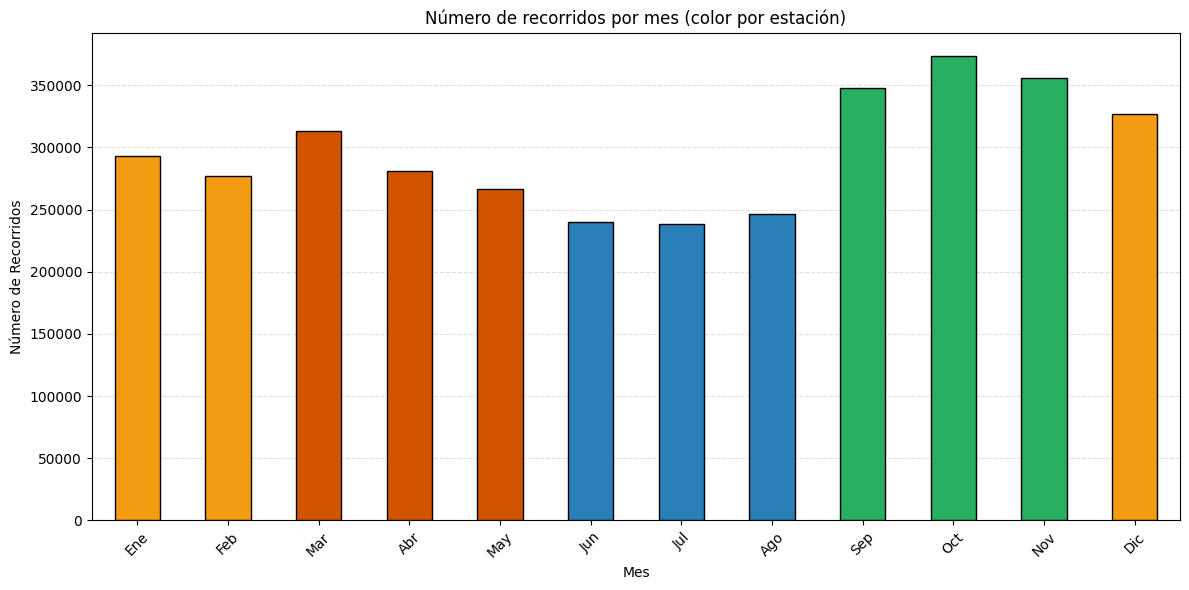

In [22]:
rides_df['fecha_origen_recorrido'] = pd.to_datetime(rides_df['fecha_origen_recorrido'])
rides_df['mes'] = rides_df['fecha_origen_recorrido'].dt.month


counts = rides_df['mes'].value_counts().reindex(range(1,13), fill_value=0).sort_index()

# Verano: Dic-Ene-Feb; Otoño: Mar-Abr-May; Invierno: Jun-Jul-Ago; Primavera: Sep-Oct-Nov
season_of = {12:'verano', 1:'verano', 2:'verano',
             3:'otoño', 4:'otoño', 5:'otoño',
             6:'invierno', 7:'invierno', 8:'invierno',
             9:'primavera', 10:'primavera', 11:'primavera'}
palette = {'verano':'#F39C12', 'otoño':'#D35400', 'invierno':'#2980B9', 'primavera':'#27AE60'}
colors = [palette[season_of[m]] for m in counts.index]

fig, ax = plt.subplots(figsize=(12, 6))
counts.plot(kind='bar', ax=ax, color=colors, edgecolor='black', zorder=3)

ax.grid(axis='y', linestyle='--', alpha=0.4, zorder=0)
ax.set_axisbelow(True)

ax.set_title('Número de recorridos por mes (color por estación)')
ax.set_xlabel('Mes'); ax.set_ylabel('Número de Recorridos')
ax.set_xticks(range(12))
ax.set_xticklabels(['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic'], rotation=45)

plt.tight_layout()
plt.show()


In [23]:
# El usuario que más tiempo usó las bicicletas
user_durations = rides_df.groupby('id_usuario')['duracion_recorrido'].sum()
max_user_id = user_durations.idxmax()
max_user_duration = user_durations.max()

print(f"Usuario más activo: {max_user_duration/3600:.2f} hs")

Usuario más activo: 738.33 hs
